In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

def compute_residuals(df):
    df = df.copy()
    df['residual'] = df['score_diff'] - df['pred_score_diff']
    df['abs_error'] = df['residual'].abs()
    return df

def compute_direction_accuracy(df):
    df = df.copy()
    df['actual_win'] = df['score_diff'] > 0
    df['pred_win'] = df['pred_score_diff'] > 0
    df['correct_direction'] = df['actual_win'] == df['pred_win']
    accuracy = df['correct_direction'].mean()
    return df, accuracy

def compute_profit_by_moneyline(df):
    # Filter only rows where a bet was placed (either A or B)
    bets_df = df[df['bet_team'].isin(['A', 'B'])].copy()

    # Normalize moneyline depending on bet side
    bets_df['effective_moneyline'] = np.where(
        bets_df['bet_team'] == 'A',
        bets_df['teamA_moneyLine'],
        bets_df['teamB_moneyLine']
    )

    # Bin the effective moneylines
    bets_df['moneyline_bin'] = pd.cut(
        bets_df['effective_moneyline'],
        bins=[-1000, -200, -100, 0, 100, 200, 500, 1000, 2000]
    )

    # Group by bin
    profit_by_odds = (
        bets_df.groupby('moneyline_bin')['profit']
        .agg(['count', 'sum', 'mean'])
        .reset_index()
        .rename(columns={
            'count': 'Num Bets',
            'sum': 'Total Profit',
            'mean': 'Avg Profit per Bet'
        })
    )
    return profit_by_odds

def compute_feature_correlation(df):
    # Include only rows without NaNs in selected features
    feature_cols = [
        'fg_pct_diff', 'ft_pct_diff', 'fg3_pct_diff',
        'ast_diff', 'reb_diff', 'moneyline_diff',
        'spread', 'score_diff'
    ]
    df_filtered = df.dropna(subset=feature_cols)
    correlation_matrix = df_filtered[feature_cols].corr()
    return correlation_matrix

/var/folders/9r/gvxmfp9n2f755ttktlmwy7rm0000gn/T/ipykernel_28279/4169792780.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bets_df.groupby('moneyline_bin')['profit']
/Users/daohengniu/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


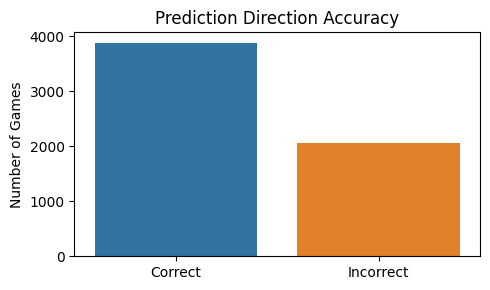

/Users/daohengniu/miniconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


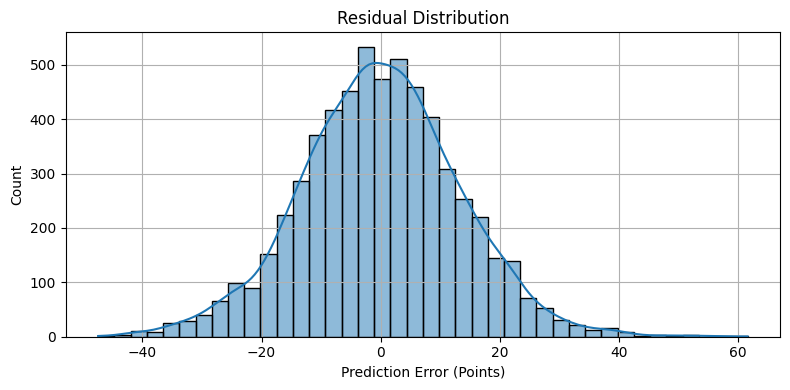

/Users/daohengniu/miniconda3/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


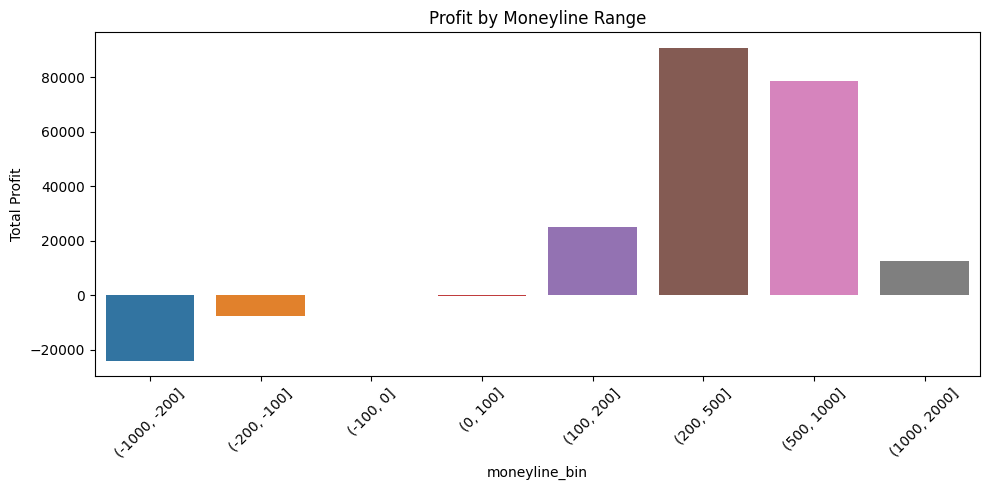

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
final_df = pd.read_csv("model_predictions.csv")

# Run analysis functions
final_df = compute_residuals(final_df)
final_df, direction_accuracy = compute_direction_accuracy(final_df)
profit_by_odds = compute_profit_by_moneyline(final_df)
#correlations = compute_feature_correlation(final_df)

# Plot Prediction Direction Accuracy
plt.figure(figsize=(5, 3))
sns.barplot(x=["Correct", "Incorrect"],
            y=[final_df['correct_direction'].sum(), (~final_df['correct_direction']).sum()])
plt.title("Prediction Direction Accuracy")
plt.ylabel("Number of Games")
plt.tight_layout()
plt.show()

# Plot Residual Distribution
plt.figure(figsize=(8, 4))
sns.histplot(final_df['residual'], bins=40, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Prediction Error (Points)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Profit by Moneyline Range
plt.figure(figsize=(10, 5))
sns.barplot(data=profit_by_odds, x='moneyline_bin', y='Total Profit')
plt.title("Profit by Moneyline Range")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()